In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import os
import math
import pickle
from detect_peaks import detect_peaks
import ruptures as rpt

import keras
from os import listdir, walk
from os.path import isfile, join
from detect_peaks import detect_peaks
import ruptures as rpt
import tensorflow as tf
from keras import layers, models
# from keras.models import Sequentia
# from keras.layers import LSTM, GRU, Dropout, Dense, Input, Flatten
# from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import load_model
from keras import optimizers 
from keras import Model
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn import preprocessing

Using TensorFlow backend.
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
%run load_dataset.ipynb

In [3]:
subj_range = np.hstack(np.arange(3001,3007))

all_patients = [str(i) for i in subj_range]

In [4]:
X_all_p, y_all_p, subj_all_p, ts_all_p, hr_all_p = load_all_data(all_patients)

Loading 3001's data
Loading 3002's data
Loading 3003's data
Loading 3004's data
Loading 3005's data
Loading 3006's data
Finished loading


In [5]:
X_all_p.shape

(10998, 3)

In [6]:
%run preprocessing.ipynb

In [7]:
new_label_list = [0,1,2,3]
new_label_dict = {
    0: 'sit',
    1: 'sleep',
    2: 'stand',
    3: 'walk'
}

colors = ['r','g','b','navy','turquoise','blue','darkviolet','gold','pink']

In [8]:
all_subjects = all_patients

plotting  sit
(3, 374)
(3, 374)
(3, 374)
(3, 374)
(3, 374)
(3, 374)


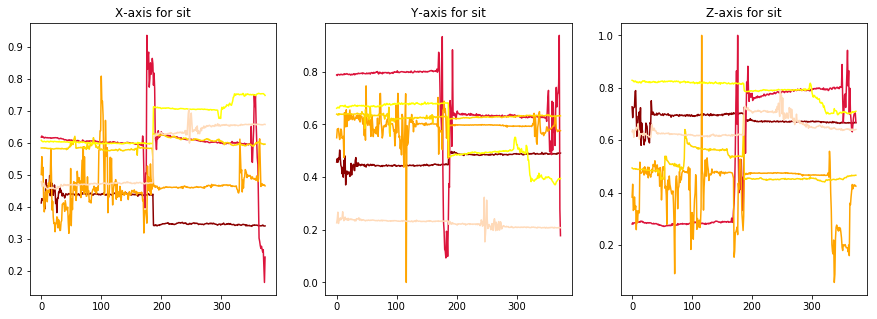

plotting  sleep
(3, 374)
(3, 374)
(3, 372)
(3, 380)
(3, 380)
(3, 373)


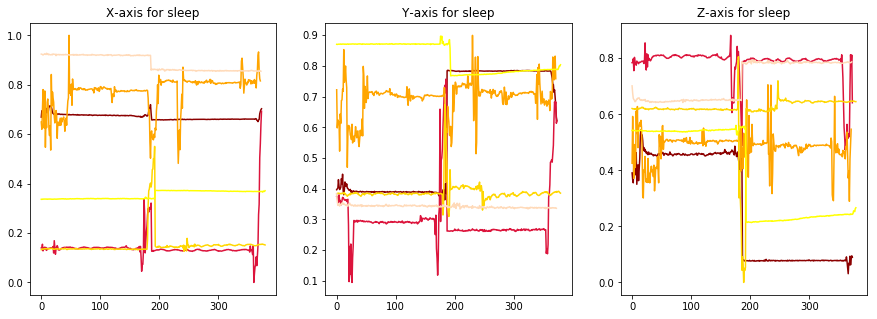

plotting  stand
(3, 573)
(3, 561)
(3, 558)
(3, 561)
(3, 561)
(3, 560)


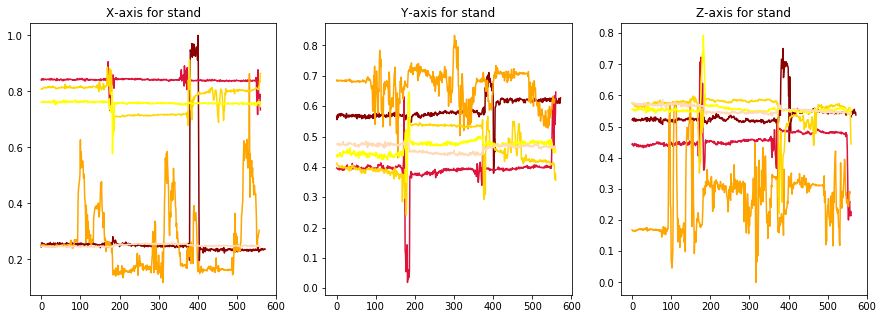

plotting  walk
(3, 386)
(3, 374)
(3, 379)
(3, 373)
(3, 367)
(3, 1248)


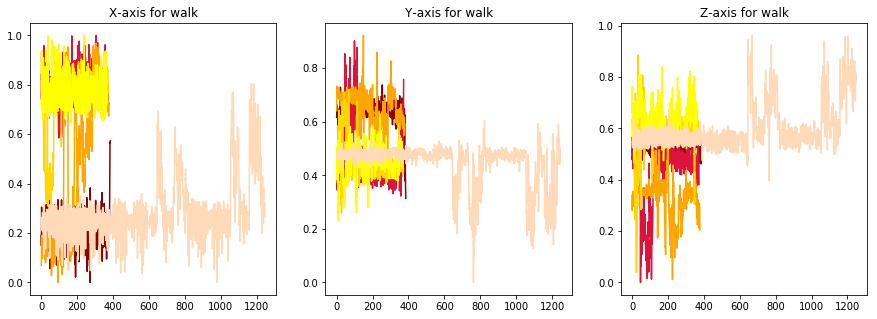

In [9]:
X_label, y_label = label_grouping(X_all_p, y_all_p, subj_all_p, all_patients, new_label_list)
plot_all_label(X_label, y_all_p, new_label_list, new_label_dict)

In [121]:
# this shape only Dense
x_pure, y_pure = prepare_pure_label(X_all_p, y_all_p, subj_all_p, all_patients, new_label_list)

In [122]:
# This reshape only cnn to GRU/LSTM
x_pure = x_pure.reshape(-1,60,3,1)

In [98]:
# This reshape other model
x_pure = x_pure.reshape(-1,60,3)

In [123]:
y_pure.shape

(10758,)

In [124]:
y_pure = np_utils.to_categorical(y_pure, 4)

In [125]:
y_pure.shape

(10758, 4)

In [126]:
X_train, X_valid, y_train,  y_valid = train_test_split(x_pure, y_pure, test_size=0.2, random_state=200)

In [127]:
X_train.shape, y_train.shape

((8606, 60, 3, 1), (8606, 4))

In [128]:
def buildModelDense():
    inp = layers.Input(shape=(180,))
    mod = layers.Dense(256, activation="relu")(inp)
#     mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(128, activation="relu")(mod)
#     mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelGru():
    inp = layers.Input(shape=(60,3,))
    mod = layers.GRU(256, activation="relu", return_sequences=True)(inp)
#     mod = layers.Dropout(0.2)(mod)
    mod = layers.GRU(256, activation="relu", return_sequences=True)(mod)
#     mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
    mod = layers.Flatten()(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelCNNGRU():
    inp = layers.Input(shape=(60,3,1))
    mod = layers.TimeDistributed(layers.Conv1D(64, 3, activation="relu"))(inp)
#     mod = layers.Dropout(0.2)(mod)
    mod = layers.TimeDistributed(layers.Flatten())(mod)
    mod = layers.GRU(64, activation="relu", return_sequences=True)(mod)
#     mod = layers.Dropout(0.2)(mod)
    mod = layers.Flatten()(mod)
    mod = layers.Dense(64, activation="relu")(mod)
#     mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelCNN():
    inp = layers.Input(shape=(60,3))
    mod = layers.Conv1D(64, 3, activation="relu")(inp)
#     mod = layers.Dropout(0.2)(mod)
    mod = layers.Conv1D(64, 3, activation="relu")(mod)
    mod = layers.MaxPooling1D(2)(mod)
#     mod = layers.Dropout(0.2)(mod)
    mod = layers.Flatten()(mod)
    mod = layers.Dense(64, activation="relu")(mod)
#     mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelCNNLSTM():
    inp = layers.Input(shape=(60,3,1))
    mod = layers.TimeDistributed(layers.Conv1D(64, 3, activation="relu"))(inp)
#     mod = layers.Dropout(0.2)(mod)
    mod = layers.TimeDistributed(layers.Flatten())(mod)
    mod = layers.LSTM(64, activation="relu", return_sequences=True)(mod)
#     mod = layers.Dropout(0.2)(mod)
    mod = layers.Flatten()(mod)
    mod = layers.Dense(64, activation="relu")(mod)
#     mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelLstm():
    inp = layers.Input(shape=(60,3,))
    mod = layers.LSTM(64, activation="relu", return_sequences=True)(inp)
#     mod = layers.Dropout(0.2)(mod)
    mod = layers.LSTM(64, activation="relu", return_sequences=True)(mod)
#     mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
    mod = layers.Flatten()(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

In [129]:
Epoch = 100
batch = 128
early_stopping = EarlyStopping(patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10, min_lr=0.001)

In [146]:
#model_1 = buildModelDense()
# model_2 = buildModelGru()
#model_3 = buildModelCNNGRU()
model_4 = buildModelCNN()
#model_5 = buildModelCNNLSTM()
#model_6 = buildModelLstm()

In [147]:
# model_1.summary()
# model_2.summary()
# model_3.summary()
model_4.summary()
# model_5.summary()
# model_6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 60, 3)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 58, 64)            640       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 56, 64)            12352     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 28, 64)            0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1792)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                114752    
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 260       
Total para

In [132]:
# history_1 = model_1.fit(X_train,y_train,batch_size=batch,epochs=Epoch,validation_data=(X_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])
# history_2 = model_2.fit(X_train,y_train,batch_size=batch,epochs=Epoch,validation_data=(X_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])
history_3 = model_3.fit(X_train,y_train,batch_size=batch,epochs=Epoch,validation_data=(X_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])
# history_4 = model_4.fit(X_train,y_train,batch_size=batch,epochs=batch,validation_data=(X_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])
history_5 = model_5.fit(X_train,y_train,batch_size=batch,epochs=Epoch,validation_data=(X_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])
# history_6 = model_6.fit(X_train,y_train,batch_size=batch,epochs=Epoch,validation_data=(X_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])

Train on 8606 samples, validate on 2152 samples
Epoch 1/100
8606/8606 [==============================] - 5s 545us/step - loss: 1.3450 - acc: 0.3249 - val_loss: 1.2379 - val_acc: 0.3778
Epoch 2/100
8606/8606 [==============================] - 3s 303us/step - loss: 1.1598 - acc: 0.4924 - val_loss: 1.0975 - val_acc: 0.5562
Epoch 3/100
8606/8606 [==============================] - 3s 306us/step - loss: 0.9405 - acc: 0.5756 - val_loss: 0.7633 - val_acc: 0.6394
Epoch 4/100
8606/8606 [==============================] - 3s 305us/step - loss: 0.6361 - acc: 0.7025 - val_loss: 0.5061 - val_acc: 0.7565
Epoch 5/100
8606/8606 [==============================] - 3s 329us/step - loss: 0.4893 - acc: 0.7872 - val_loss: 0.4785 - val_acc: 0.8346
Epoch 6/100
8606/8606 [==============================] - 3s 329us/step - loss: 0.4636 - acc: 0.8154 - val_loss: 0.4365 - val_acc: 0.7779
Epoch 7/100
8606/8606 [==============================] - 3s 325us/step - loss: 0.3756 - acc: 0.8456 - val_loss: 0.3283 - val_acc: 

In [35]:
%run eval_score.ipynb

In [142]:
y_pred = model_5.predict(X_valid)
y_pred = y_pred.argmax(axis=1)

1.0


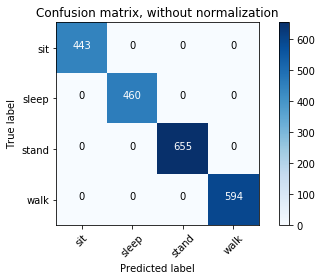

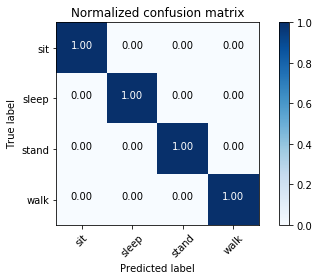

              precision    recall  f1-score   support

         sit       1.00      1.00      1.00       443
       sleep       1.00      1.00      1.00       460
       stand       1.00      1.00      1.00       655
        walk       1.00      1.00      1.00       594

   micro avg       1.00      1.00      1.00      2152
   macro avg       1.00      1.00      1.00      2152
weighted avg       1.00      1.00      1.00      2152



In [143]:
acc = accuracy_score(y_valid.argmax(axis=1), y_pred)
print(acc)

show_conf_matrix(y_valid.argmax(axis=1), y_pred, LABELS)
show_clf_report(y_valid.argmax(axis=1), y_pred, LABELS)

In [157]:
subj = np.hstack(np.arange(['4001','4002','4003','4004']))
all_test = [str(i) for i in subj]

TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [168]:
all_test = ['4001','4002','4003','4004']

In [169]:
X_all_test, y_all_test, subj_all_test, ts_all_test, hr_all_test = load_all_data(all_test)

Loading 4001's data
Loading 4002's data
Loading 4003's data
Loading 4004's data
Finished loading


In [137]:
x_test, y_test = prepare_pure_label(X_all_test, y_all_test, subj_all_test, all_test, new_label_list)

In [138]:
x_test.shape

(3851, 180)

In [139]:
# This shape only CNN + Gru/LSTM
x_test = x_test.reshape(-1,60,3,1)

In [111]:
x_test = x_test.reshape(-1,60,3)

In [144]:
y_pred = model_5.predict(x_test)
y_pred = y_pred.argmax(axis=1)

0.46507400675149313


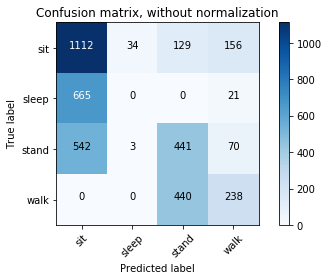

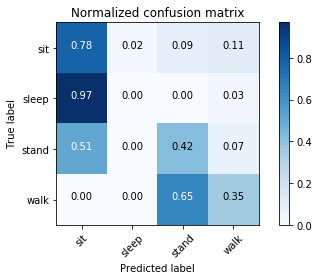

              precision    recall  f1-score   support

         sit       0.48      0.78      0.59      1431
       sleep       0.00      0.00      0.00       686
       stand       0.44      0.42      0.43      1056
        walk       0.49      0.35      0.41       678

   micro avg       0.47      0.47      0.47      3851
   macro avg       0.35      0.39      0.36      3851
weighted avg       0.38      0.47      0.41      3851



In [145]:
acc = accuracy_score(y_test, y_pred)
print(acc)

show_conf_matrix(y_test, y_pred, LABELS)
show_clf_report(y_test, y_pred, LABELS)

In [ ]:
LABELS = {0:'Sitting',
          1:'Sleeping',
          2:'Standing',
          3:'Walking'}
# The number of steps within one time segment
TIME_PERIODS = 60
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 30

In [ ]:
def read_data(file_path):

    column_names = ['id',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis',
                    'activity']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 

def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

In [ ]:
df = read_data('Full3001-3006.csv')

In [ ]:
show_basic_dataframe_info(df)
df.head(20)

In [ ]:
df_test = df[df['id'] > '3004']
df_train = df[df['id'] <= '3004']

In [ ]:
df_train.shape

In [ ]:
df_test.shape

In [ ]:
LABEL = 'activity'

In [ ]:
df_train = 

In [ ]:
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)
x_test,y_test = create_segments_and_labels(df_test,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [ ]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

In [ ]:
print('x_train shape: ', x_test.shape)
print(x_test.shape[0], 'training samples')
print('y_train shape: ', y_test.shape)

In [ ]:
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2],4

In [ ]:
input_shape = (n_timesteps*n_features)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

In [ ]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [ ]:
y_train_hot = np_utils.to_categorical(y_train, n_outputs)
print('New y_train shape: ', y_train_hot.shape)

In [ ]:
#Normalize
def scale_data(trainX, testX, standardize=True):
	# remove overlap
	#cut = int(trainX.shape[1] / 2)
	#longX = trainX[:, -cut:, :]
	# flatten windows
	#longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	# flatten train and test
	flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
	flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))
	# standardize
	if standardize:
		s = StandardScaler()
		# fit on training data
		s.fit(longX)
		# apply to training and test data
		longX = s.transform(longX)
		flatTrainX = s.transform(flatTrainX)
		flatTestX = s.transform(flatTestX)
	# reshape
	flatTrainX = flatTrainX.reshape((trainX.shape))
	flatTestX = flatTestX.reshape((testX.shape))
	return flatTrainX, flatTestX

In [ ]:
df_train,df_test = scale_data(df_train,df_test)

In [ ]:
def build_lstm_model(n_timesteps, n_features, n_outputs):
    
  
  ######## TODO 3 ########
    inp = Input((n_timesteps, n_features))
    x = LSTM(units=64, activation='relu', return_sequences=True)(inp)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation='relu')(x)
    outp = Dense(n_outputs, activation='softmax')(x)
    model = Model(inp, outp)
    return model

In [ ]:
model = build_lstm_model(n_timesteps, n_features, n_outputs)